In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 133
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 1
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "recurent-v2"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 32
epochs = 150
learning_rate = 1e-4

workers = 4

# Part One: The Line

## Data

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y[:,0,:])
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

## Model

In [4]:
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)

x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)

x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

## Training

In [6]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/150
1000/1000 [==============================] - 231s 231ms/step - loss: 0.0820
Epoch 2/150
1000/1000 [==============================] - 231s 231ms/step - loss: 0.0397
Epoch 3/150
1000/1000 [==============================] - 242s 242ms/step - loss: 0.0314
Epoch 4/150
1000/1000 [==============================] - 243s 243ms/step - loss: 0.0287
Epoch 5/150
1000/1000 [==============================] - 244s 244ms/step - loss: 0.0258
Epoch 6/150
1000/1000 [==============================] - 237s 237ms/step - loss: 0.0227
Epoch 7/150
1000/1000 [==============================] - 236s 236ms/step - loss: 0.0192
Epoch 8/150
1000/1000 [==============================] - 235s 235ms/step - loss: 0.0176
Epoch 9/150
1000/1000 [==============================] - 236s 236ms/step - loss: 0.0160
Epoch 10/150
1000/1000 [==============================] - 236s 236ms/step - loss: 0.0147
Epoch 11/150
1000/1000 [==============================] - 228s 228ms/step - loss: 0.0140
Epoch 12/150
1000/1000 [======

KeyboardInterrupt: 

In [7]:
autoencoder.save_weights('saved_models/'+name)

In [6]:
autoencoder.load_weights('saved_models/'+name)

&lt;tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7feb670b0640&gt;

## Results

(120, 3)


&lt;matplotlib.image.AxesImage at 0x7fb0c05470d0&gt;

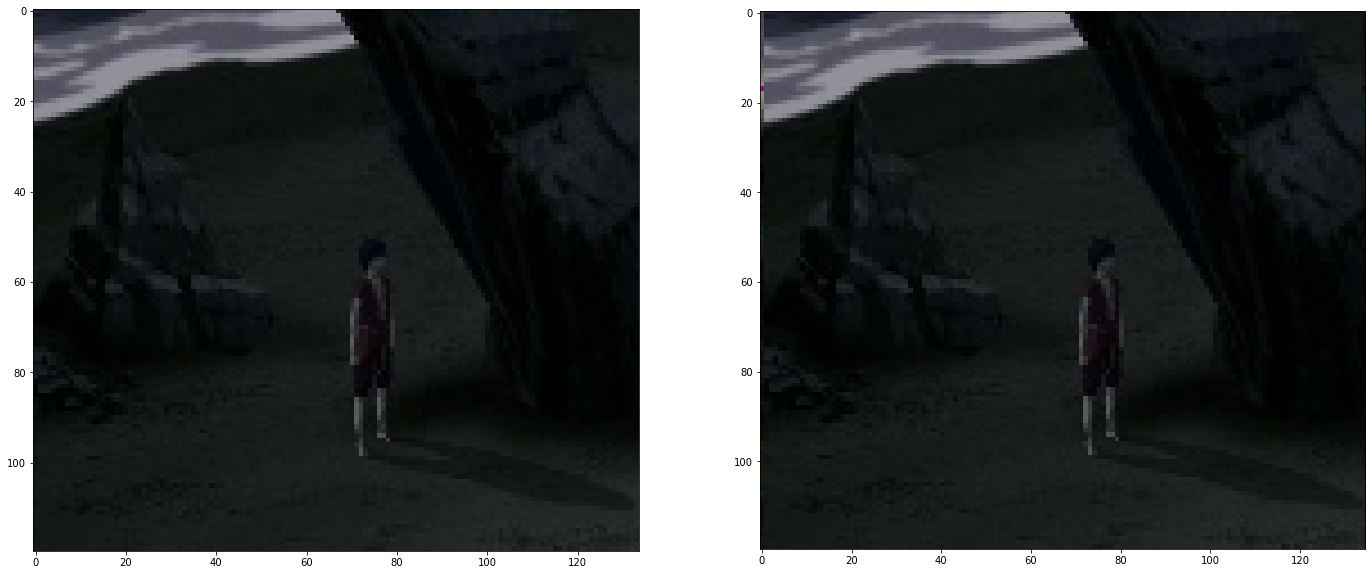

In [8]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)[:,0,:]
print(image_y_true.shape)
image_y_true = np.expand_dims(image_y_true, axis=1)
image_y_pred = autoencoder.predict(np.expand_dims(image_x, 0))[0]
image_y_pred = np.expand_dims(image_y_pred, axis=1)
image_y_pred_flip = autoencoder.predict(np.expand_dims(np.flip(image_x, axis=1), 0))[0]
image_y_pred_flip = np.flip(image_y_pred_flip, axis=1)
image_y_pred_flip = np.expand_dims(image_y_pred_flip, axis=1)
image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred), axis=1)
image_pred = np.concatenate((image_y_pred_flip, image_pred), axis=1)
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


&lt;matplotlib.image.AxesImage at 0x7fb0c044b5e0&gt;

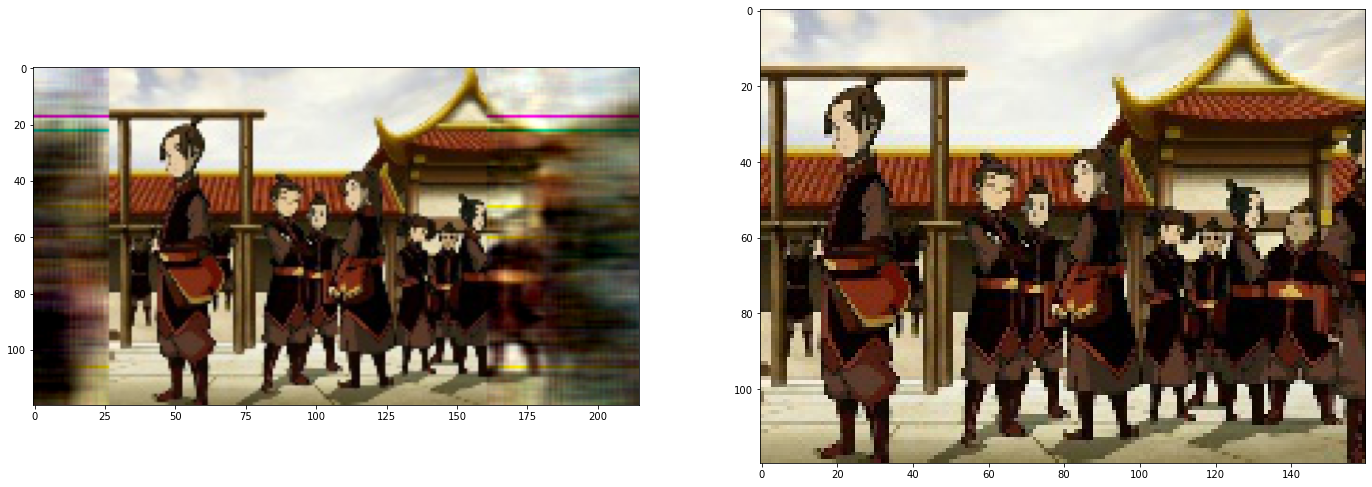

In [12]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_x_true = image_x
image_x_flip = np.flip(image_x, axis=1)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
slices = []
slices_flip = []
image_y_flip = np.expand_dims(image_x_flip[:,-1,:], axis=1)

for i in range(0, 2*27):
    #slice_y = np.expand_dims(slices[-1], axis=1)
    slice_y = autoencoder.predict(np.expand_dims(image_x[:,i:,:], 0))[0]
    slice_y = np.expand_dims(slice_y, axis=1)
    slices.append(slice_y)
    image_x = np.concatenate((image_x, slice_y), axis=1)

for i in range(27):
    slice_y = autoencoder.predict(np.expand_dims(image_x_flip[:,i:,:], 0))[0]
    slice_y = np.expand_dims(slice_y, axis=1)
    slices_flip.append(slice_y)
    image_x_flip = np.concatenate((image_x_flip, slice_y), axis=1)
    image_y_flip = np.concatenate((image_y_flip, slice_y), axis=1)
image_y_flip = np.flip(image_y_flip, axis=1)

image_true = np.concatenate((image_x_true, image_y_true), axis=1)

image_x = np.concatenate((image_y_flip, image_x), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_x)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_true)

# Part 2: Sequence

## Data

In [9]:
class DataGenerator2(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X_images = []
                    for i in range(27):
                        temp = np.concatenate((image_x[:,i:,:], image_y[:,:i,:]), axis=1)
                        X_images.append(temp)
                    X_images = np.array(X_images)
                    X.append(X_images)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)

        X = np.array(X)
        Y = np.swapaxes(Y,1,2)

        return X, Y

## Model

In [ ]:
input_x = Input(shape=(120,))

## Training